# Optimizing Gradient Descent for Neural Networks

In this notebook, we will explore different gradient descent optimization algorithms and their effect on the error surface and the optimization process on the whole.

We will use Neural Network that uses gradient descent and modify it to allow for different optimizers.
We will implement the following:
    - Gradient Descent
    - Momentum
    - Nesterov Accelerated Gradient
    - RMS Prop

**Gradient Descent** <br/>
<br/>
Gradient Descent is the first-order iterative optimization algorithm to find minimum of a function $J$($\theta$). In literature, the function is usually referred as "Objective function".
To find the minimum point $\theta$<sub>$min$</sub> of the objective function, the algorithm takes steps in the direction of negative slope of the function from its starting point. The step size for updation of the minimum is dictated by the learning rate.

The remaning three algorithms mentioned above are widely used by the Deep Learning community to deal with the common challeneges faced in optimization. We briefly discuss them below.

There are three variants of Gradient Descent based on the amount of the data used. <br/>
1. Batch Gradient Descent
2. Stochastic Gradient Descent
3. Mini-batch Gradient Descent

**Batch Gradient Descent** computes the gradient of the objective function with respect to the parameter $\theta$ for the whole training dataset to form one update. This results in the algorithm being slow and unfit for very large datasets. Batch gradient descent is relatively stable and finds exact global optimum for the convex functions and local optimum for the non-convex functions. <br/> <br/> 
**Stochastic Gradient Descent** computes the gradient followed by an update for every example in the training dataset. This results in SGD being faster than the BGD. SGD can therefore be also used to train over the examples on the fly. One important advantage of the SGD over BGD is that with the examples on the fly, SGD has the potential to land on a better optimum while not remaining restricted to the same basin of the parameter values like BGD. <br/> <br/>
**Mini-batch Gradient Descent** combines the advantages of both SGD and BGD. Mini-batch Gradient descent computes the gradient of the function and performs an update in the parameter value for every $n$ set of examples in the training data.

Mini-batch Gradient Descent optimization lacks good convergence for the following reasons: <br/>

- It might get stuck around local suboptimal minimas or even saddle points.
- The choice of learning rate is problematic. A small learning rate can lead to slow convergence  while a learning rate that is large might result in the fluctuation of the algorithm around the optimal point. Also, the same learning rate for all the parameter updates might be unfit because not all the features need to be updated to the same extent.

Let's look at the different versions of Gradient Descent used to cope with the challenegs above.

**Momentum** <br/>
<br/>
The areas of the objective function where surface curves occur more steeply in one dimension compared to the others, the Stochastic Gradient Descent algorithm finds it troubling to navigate and become very slow in finding the local optimum. <br/>
Momentum is a method that helps accelarate SGD in the direction towards the minimum and dampens the oscillations with the use of $\gamma$ in its update equation:

\begin{equation*}
x_t = x_{t-1} + \gamma \nabla J(\theta)
\end{equation*}

\begin{equation*}
\theta = \theta - x_t
\end{equation*}

**Nesterov Accelerated Gradient** <br/> <br/>
NAG algorithm approximates the slope of the next point using which it makes the decision about the parameter update. This gives the algorithm the knowledge of the direction it is moving ahead. The benefit of this extra calculation is to slow down the roll of the algorithm towards the minima before the slope starts to turn positive again. 

\begin{equation*}
x_t = x_{t-1} + \gamma \nabla J(\theta - \gamma x_{t-1})
\end{equation*}
\begin{equation*}
\theta = \theta - x_t
\end{equation*}

**RMS Prop**
<br/>
RMSprop is an algorithm that aims to diminish the agressive and monotonically dereasing learning rate for another algorithm **Adadelta** that we do not discuss in this article. 
The update equation for RMS prop is given below: <br/>


\begin{equation*}
E[g^2]_t = 0.9E[g^2]_{t-1} + 0.1g_t^2
\end{equation*}

\begin{equation*}
\theta = \theta - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}}
\end{equation*}


We have the following visualization code to show the error surface and the path the model takes during training. We will see how the error surface changes for different datasets and how the optimization path changes due to a different optimizer.

In [9]:
# Helper functions

def get_error_surface(w1, w2, cls, data):
    model = NeuralNetwork('sgd')
    z = np.zeros_like(w1)
    for row in range(w1.shape[0]):
        for col in range(w1.shape[1]):
            model.weights_[0] = np.array([w1[row,col], w2[row,col]])
            loss = model.evaluate(*data)
            z[row,col] = loss
    return z

def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole ggid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

We import all the libraries in the next cell that we might need to use in this notebook.

In [10]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pydot
from tqdm import tqdm_notebook

from IPython.display import Image
from ipywidgets import interact, fixed, IntSlider, Play, HBox, jslink

from sklearn.datasets import make_moons, make_circles, make_blobs
from keras.models import Sequential
from keras.layers import Activation, Dense
import keras.backend as k
from sklearn.model_selection import train_test_split

In [11]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def __init__(self, optimizer):
        '''Creates a Feed-Forward Neural Network.
        "optimizer" is the particular gradient descent strategy used for weight update'''
        self.num_layers = 2 # includes input layer
        self.nodes_per_layer = [2,1]
        self.input_shape = 2
        self.output_shape = 1
        self.optimizer = optimizer
        
        # Values needed for more sophisticated optimizers which require saved state
        self.past_update_amount = 0
        
        self.__init_weights()
    
    def __init_weights(self):
        '''Initializes weights to a dummy value which is better for visualization'''
        self.weights_ = []
        self.weights_.append(np.array([[-10.0,-10.0]]).T)
    
    def fit(self, Xs, Ys, epochs, lr=1e-3, gamma=0.9):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch as well as lists containing weight values for each epoch.'''
        history = []
        w_hist1 = []
        w_hist2 = []
        for epoch in tqdm_notebook(range(epochs)):
            activations = self.forward_pass(Xs)
            deltas = self.backward_pass(Ys, activations)
            
            layer_inputs = [Xs] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr, gamma, Ys)
                    
            preds = self.predict(Xs)
            current_loss = self.mean_squared_error(preds, Ys)
            history.append(current_loss)
            w_hist1.append(self.weights_[0][0][0])
            w_hist2.append(self.weights_[0][1][0])
        return history, w_hist1, w_hist2
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        
        a = input_data.dot(self.weights_[0])
        z = self.sigmoid(a)
        activations.append(z)
        
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = []
    
        activation_deriv = np.multiply(layer_activations[-1], 1-layer_activations[-1])
        delta = np.multiply((layer_activations[-1] - targets), activation_deriv)
        deltas.append(delta)
        
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr, gamma, targets):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate
        "gamma" is the momentum parameter'''
        gradient = np.dot(deltas[0].T, layer_inputs[0]).T
        
        if self.optimizer == 'sgd':
            update_amount = lr * gradient
        elif self.optimizer == 'momentum':
            self.past_update_amount = gamma*self.past_update_amount + lr*gradient
            update_amount = self.past_update_amount
        elif self.optimizer == 'nag':
            weights_original = self.weights_[0]
            self.weights_[0] -= gamma*self.past_update_amount
            
            activations_ahead = self.forward_pass(layer_inputs[0])
            deltas_ahead = self.backward_pass(targets, activations_ahead)
            gradient = np.dot(deltas_ahead[0].T, layer_inputs[0]).T
            self.past_update_amount = gamma*self.past_update_amount + lr*gradient            
            self.weights_[0] = weights_original
            update_amount = self.past_update_amount
            
        elif self.optimizer == 'rmsprop':
            rms_prop = gamma * self.past_update_amount + (1-gamma) * (gradient ** 2)
            self.past_update_amount = rms_prop
            update_amount = (lr * gradient) / np.sqrt(rms_prop + gamma)
            
            
        self.weights_[0] -= update_amount
        
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns total MSE for given dataset'''
        pred = self.predict(Xs)
        return self.mean_squared_error(pred, Ys)

We build a simple regression dataset by putting in an arbitrary binary function and see how it affects the error surface.

In [12]:
a = np.random.uniform(low=0.0, high=0.5, size=(150,))
b = np.random.uniform(low=0.0, high=0.5, size=(150,))
dataset = pd.DataFrame({
    'var1':   a,
    'var2':   b,
    # 'output': a+b,
    'output': (a**b)+b,
})
print(dataset.shape)
dataset.head()

(150, 3)


,output,var1,var2
0,0.991217,0.302106,0.248557
1,0.990964,0.312192,0.081845
2,1.026621,0.307062,0.411328
3,0.911830,0.100998,0.080656
4,0.928666,0.188506,0.479036


We train neural networks for all the optimizers and obtain the histories of parameter updates for them.

In [13]:
epochs = 2000

In [14]:
nn = NeuralNetwork('sgd')
_,w1h_sgd,w2h_sgd = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                 epochs=epochs, lr=0.01, gamma=0.9)

nn = NeuralNetwork('momentum')
_,w1h_mome,w2h_mome = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                  epochs=epochs, lr=0.01, gamma=0.9)

nn = NeuralNetwork('nag')
_,w1h_nag,w2h_nag = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                   epochs=epochs, lr=0.01, gamma=0.9)

nn = NeuralNetwork('rmsprop')
_,w1h_rms,w2h_rms = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                   epochs=epochs, lr=0.01, gamma=0.9)

Next, tet's look at the error surface

<IPython.core.display.Javascript object>


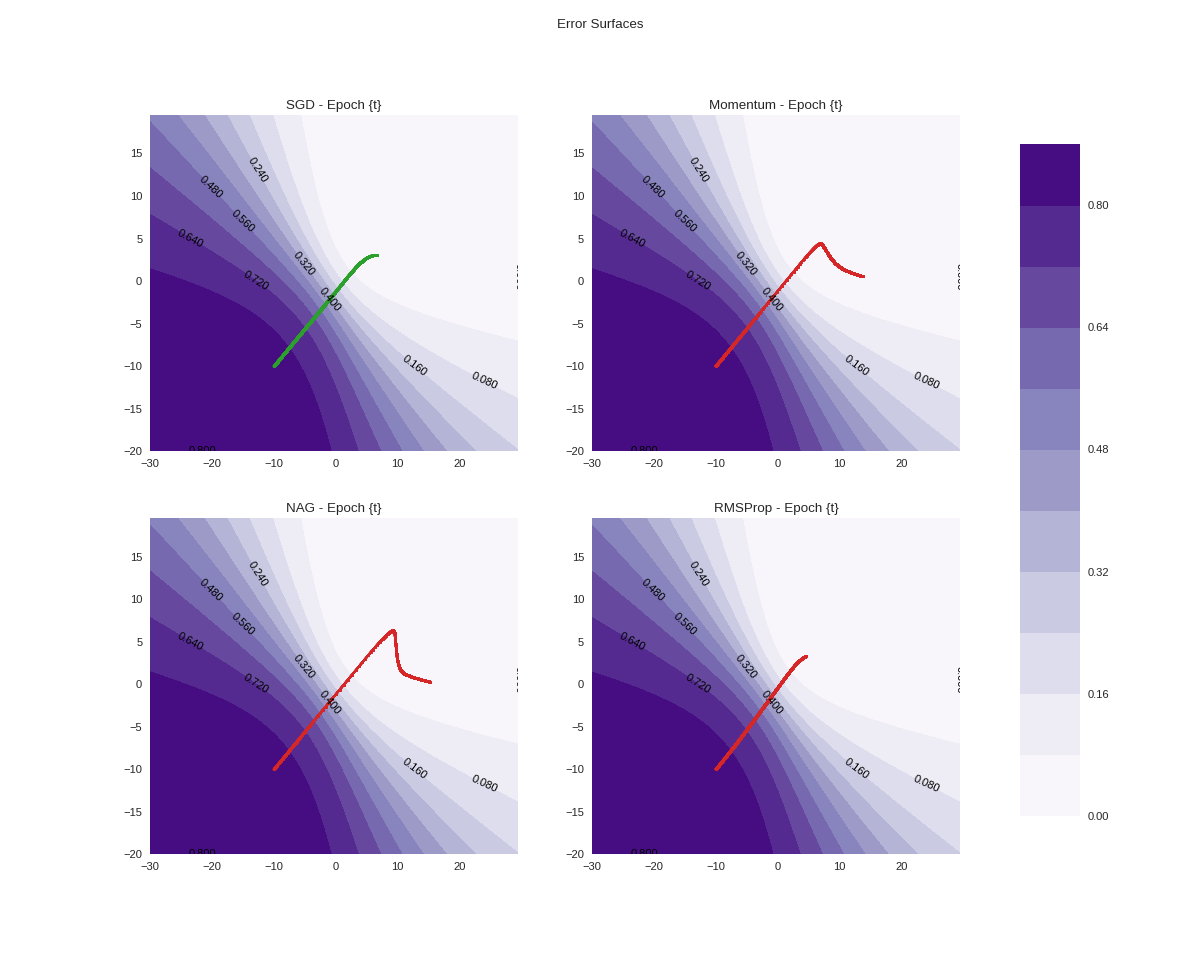

interactive(children=(Play(value=0, description='t', max=2000, step=10), Output()), _dom_classes=('widget-inte…

In [15]:
def make_viz(t):
    x = np.arange(-30,30,0.5)
    y = np.arange(-20,20,0.5)
    x, y = np.meshgrid(x, y)
    z = get_error_surface(x, y, 
                          NeuralNetwork, 
                          (dataset[['var1','var2']].values, dataset[['output']].values))
    if len(plt.gcf().axes) == 4: 
        CS = ax1.contourf(x, y, z, levels=10, cmap='Purples');
        ax1.clabel(CS, inline=False, fontsize=10, colors='k')

        CS = ax2.contourf(x, y, z, levels=10, cmap='Purples');
        ax2.clabel(CS, inline=False, fontsize=10, colors='k')
    
        CS = ax3.contourf(x, y, z, levels=10, cmap='Purples');
        ax3.clabel(CS, inline=False, fontsize=10, colors='k')
    
        CS = ax4.contourf(x, y, z, levels=10, cmap='Purples');
        ax4.clabel(CS, inline=False, fontsize=10, colors='k')

    ax1.plot(w1h_sgd[:t], w2h_sgd[:t], 
             marker='.', markersize=4, c='tab:green');
    ax1.set_title('SGD - Epoch {t}');

    ax2.plot(w1h_mome[:t], w2h_mome[:t], 
             marker='.', markersize=4, c='tab:red');
    ax2.set_title('Momentum - Epoch {t}');
    
    ax3.plot(w1h_nag[:t], w2h_nag[:t], 
             marker='.', markersize=4, c='tab:red');
    ax3.set_title('NAG - Epoch {t}');
    
    ax4.plot(w1h_rms[:t], w2h_rms[:t], 
             marker='.', markersize=4, c='tab:red');
    ax4.set_title('RMSProp - Epoch {t}');

    if len(plt.gcf().axes) == 4: 
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(CS, cax=cbar_ax)
    
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15,12), dpi=80)
fig.suptitle('Error Surfaces')
play = Play(min=0,max=epochs,step=10,value=0)
interact(make_viz, t=play);